In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import numpy as np
import scipy as sp
import elfi
from elfi.methods import BOLFI
from elfi.bo.gpy_model import GPyModel
from elfi.posteriors import BolfiPosterior
from functools import partial

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

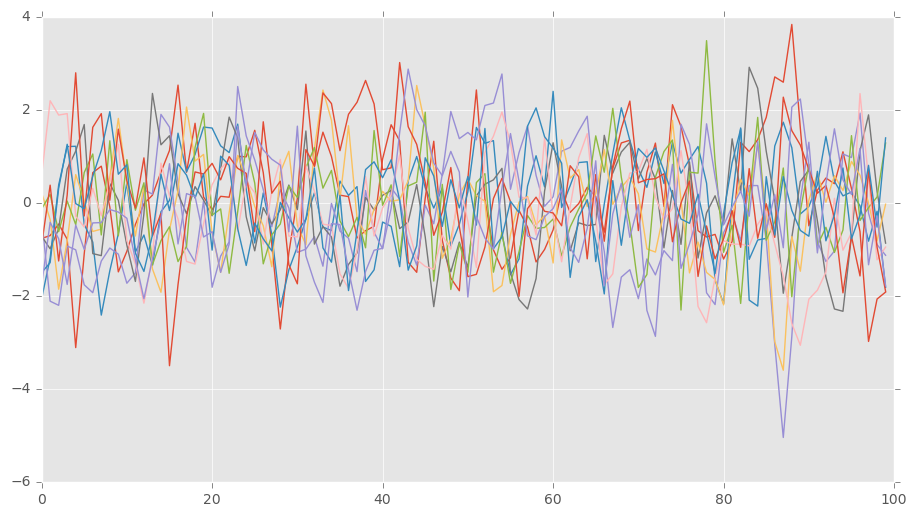

In [2]:
# population parameters: mean and variance
t1_mu, t1_s2 = 0.6, 0.2
t2_mu, t2_s2 = 0.2, 0.1

# number of observed individuals in population
n_individuals = 10

# length of observed time series per individual
n_samples = 100

def MA2(t1, t2, n_sim=1, prng=None):
    n_obs = n_samples
    if prng is None:
        prng = np.random.RandomState()
    w = prng.randn(n_sim, n_obs+2) # i.i.d. sequence ~ N(0,1)
    y = w[:,2:] + t1 * w[:,1:-1] + t2 * w[:,:-2]
    return y

# unobserved individual parameters
t1 = np.random.normal(t1_mu, t1_s2, n_individuals)
t2 = np.random.normal(t2_mu, t2_s2, n_individuals)

# observed data
y = np.zeros((n_individuals, 1, n_samples))
for ind in range(n_individuals):
    y[ind] = MA2(t1[ind], t2[ind], n_sim=1)

# plot observed data
plt.figure(figsize=(11, 6));
for ind in range(n_individuals):
    plt.plot(np.arange(0,n_samples),y[ind,0,:]);

In [3]:
def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1, keepdims=True)
    return C

def distance(x, y):
    d = np.linalg.norm( np.array(x) - np.array(y), ord=2, axis=0)
    return d

# set up autocovariance summaries
ac1 = partial(autocov, lag=1)
ac2 = partial(autocov, lag=2)

# inference parameters
batch_size = 2
n_surrogate_samples = 200
bounds = ((-2,2),
          (-2,2))
kernel_var = 0.3
kernel_scale = 0.2
noise_var = 0.01

client = elfi.env.client()

def get_individual_posterior(ind):
    """ Infer posterior for individual 'ind'.
    """
    t1 = elfi.Prior("t1", "uniform", -1, 2)
    t2 = elfi.Prior("t2", "uniform", -1, 2)
    Y = elfi.Simulator("MA2", MA2, t1, t2, observed=y[ind])
    S2 = elfi.Summary("S1", ac1, Y)
    S1 = elfi.Summary("S2", ac2, Y)
    d = elfi.Discrepancy("d", distance, S1, S2)

    gp_model = GPyModel(input_dim=len(bounds),
                        bounds=bounds,
                        kernel_var=kernel_var,
                        kernel_scale=kernel_scale,
                        noise_var=noise_var)
    bolfi = BOLFI(d,
                  [t1, t2],
                  batch_size=batch_size,
                  n_surrogate_samples=n_surrogate_samples,
                  model=gp_model,
                  client=client)
    return bolfi, bolfi.infer()

In [5]:
inferences = list()
posteriors = list()
for ind in range(n_individuals):
    b, p = get_individual_posterior(ind)
    inferences.append(b)
    posteriors.append(p)

elfi.methods - INFO - BOLFI: Sampling 200 samples in batches of 2
elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.3878) as threshold
elfi.methods - INFO - BOLFI: Sampling 200 samples in batches of 2
elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.3215) as threshold
elfi.methods - INFO - BOLFI: Sampling 200 samples in batches of 2
elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.4606) as threshold
elfi.methods - INFO - BOLFI: Sampling 200 samples in batches of 2
elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.3408) as threshold
elfi.methods - INFO - BOLFI: Sampling 200 samples in batches of 2
elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.3566) as threshold
elfi.methods - INFO - BOLFI: Sampling 200 samples in batches of 2
elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (0.2997) as threshold
elfi.methods - INFO - BOLFI:

In [6]:
def eval_2d_mesh(xmin, ymin, xmax, ymax, nx, ny, eval_fun):
    """
        Evaluate 'eval_fun' at a grid defined by max and min
        values with number of points defined by 'nx' and 'ny'.
    """
    if xmin > xmax:
        raise ValueError("xmin (%.2f) was greater than"
                         "xmax (%.2f)" % (xmin, xmax))
    if ymin > ymax:
        raise ValueError("ymin (%.2f) was greater than"
                         "ymax (%.2f)" % (xmin, xmax))
    if nx < 1 or ny < 1:
        raise ValueError("nx (%.2f) or ny (%.2f) was less than 1" % (nx, ny))
    X = np.linspace(xmin, xmax, nx)
    lenx = len(X)
    Y = np.linspace(ymin, ymax, ny)
    leny = len(Y)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros((leny, lenx))
    for i in range(leny):
        for j in range(lenx):
            Z[i][j] = eval_fun([X[i][j], Y[i][j]])
    return (X.tolist(), Y.tolist(), Z.tolist())

def plot_2d_mesh(X, Y, Z, nlevels=10, clabel=True):
    """
        Plot 2D mesh data with 'nlevels' contours.
        http://stackoverflow.com/questions/5127668/how-to-visualize-scalar-2d-data-with-matplotlib
    """
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    CS = plt.contour(X, Y, Z, nlevels)
    if clabel is True:
        plt.clabel(CS, inline=1, fontsize=10)

In [10]:
def print_posterior(post):
    for ind, p in enumerate(post):
        X, Y, Z = eval_2d_mesh(bounds[0][0], bounds[1][0], bounds[0][1], bounds[1][1], 100, 100, p.pdf)
        plot_2d_mesh(X, Y, Z)
        plt.scatter(t1[ind], t2[ind], c="k", s=100, marker="*")
        plt.show()

def estimate_MAP_statistics(post):
    MAPs = np.zeros((n_individuals, len(bounds)))
    for ind, p in enumerate(post):
        MAPs[ind] = p.MAP
    MAP_means = np.mean(MAPs, axis=0)
    MAP_stds = np.std(MAPs, axis=0, ddof=1)*2
    return MAP_means, MAP_stds

def do_new_posteriors(post, MAP_means, MAP_stds):
    new_posteriors = list()
    for ind, p in enumerate(post):
        t1 = ClippedNormalPrior()
        t1.minval = bounds[0][0]
        t1.maxval = bounds[0][1]
        t1.mean = MAP_means[0]
        t1.std = MAP_stds[0]
        t2 = ClippedNormalPrior()
        t2.minval = bounds[1][0]
        t2.maxval = bounds[1][1]
        t2.mean = MAP_means[1]
        t2.std = MAP_stds[1]
        new_post = BolfiPosterior(p.model, p.threshold)
        new_post.priors = [t1, t2]
        new_posteriors.append(new_post)
    return new_posteriors

In [11]:
class Prior():

    minval = 0.0
    maxval = 1.0

    def isValid():
        if self.minval > self.maxval:
            raise ValueError("Prior minval (%.2f) can't be larger than maxval (%.2f)" % (self.minval, self.maxval))
        return True

    def getProbDensity(self, value):
        raise NotImplementedError("Subclass implements")

    def getLogProbDensity(self, value):
        raise NotImplementedError("Subclass implements")

    def getRandomValue(self):
        raise NotImplementedError("Subclass implements")


class UniformPrior(Prior):
    """ Uniform distribution over the half-open interval [minval, maxval) """

    def isValid():
        if self.minval > self.maxval:
            raise ValueError("Prior minval (%.2f) can't be larger than maxval (%.2f)" % (self.minval, self.maxval))
        return True

    def getProbDensity(self, value):
        return 1.0 / (self.maxval - self.minval)

    def getLogProbDensity(self, value):
        return np.log(1.0) - np.log(self.maxval - self.minval)

    def getRandomValue(self):
        return np.random.uniform(self.minval, self.maxval)


class ClippedNormalPrior(Prior):
    """ Normal distribution truncated to interval [minval, maxval] """

    mean = 0.0
    std = 1.0

    def isValid():
        if self.minval > self.maxval:
            raise ValueError("Prior minval (%.2f) can't be larger than maxval (%.2f)" % (self.minval, self.maxval))
        if self.std <= 0.0:
            raise ValueError("Prior std (%.2f) must be positive" % (self.std))
        return True

    def getProbDensity(self, value):
        a, b = (self.minval - self.mean) / self.std, (self.maxval - self.mean) / self.std
        return sp.stats.truncnorm.pdf(value, a, b, self.mean, self.std)

    def getLogProbDensity(self, value):
        a, b = (self.minval - self.mean) / self.std, (self.maxval - self.mean) / self.std
        return sp.stats.truncnorm.logpdf(value, a, b, self.mean, self.std)

    def getRandomValue(self):
        a, b = (self.minval - self.mean) / self.std, (self.maxval - self.mean) / self.std
        return sp.stats.truncnorm.rvs(a, b, self.mean, self.std)

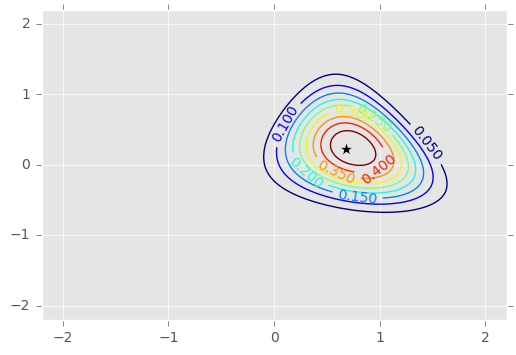

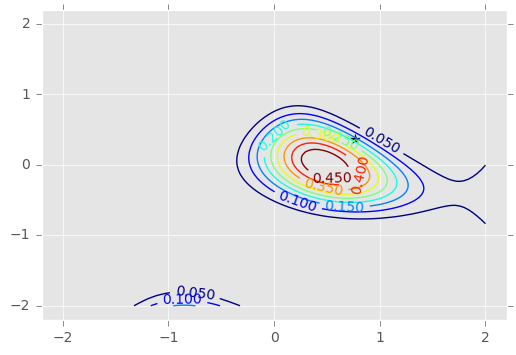

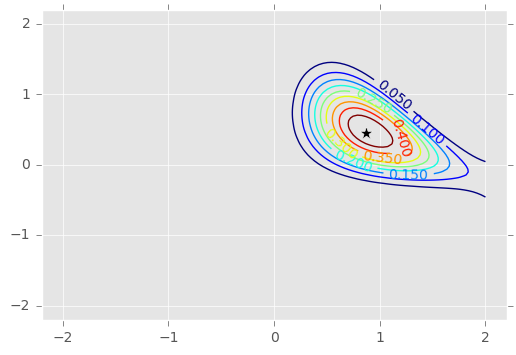

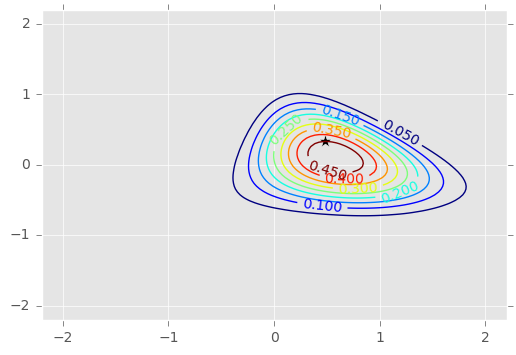

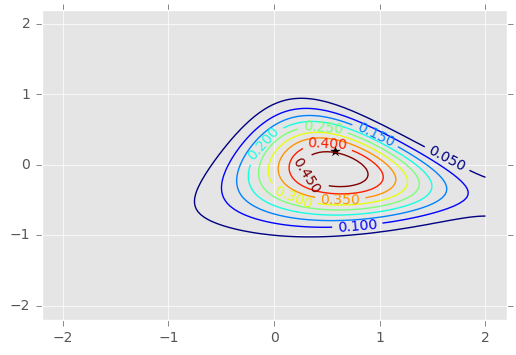

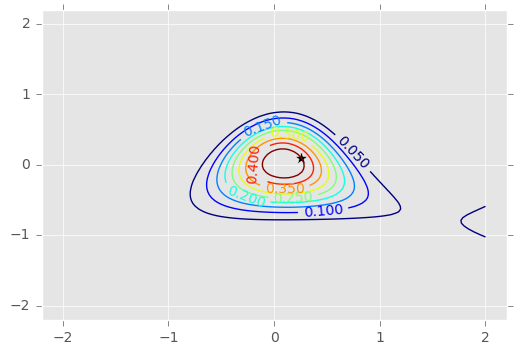

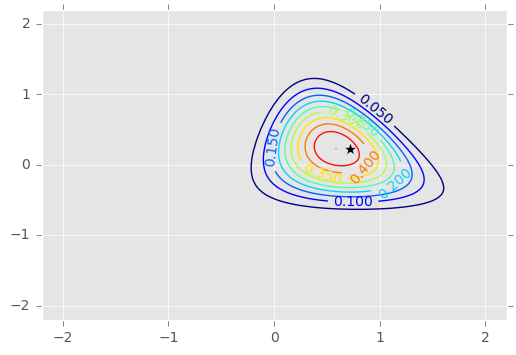

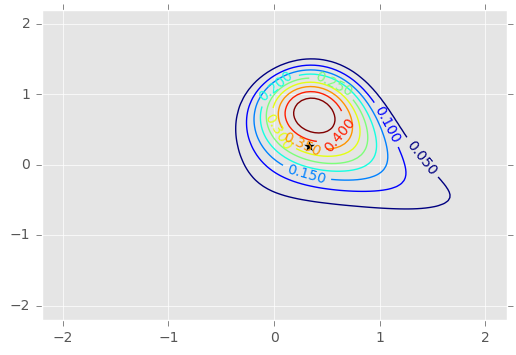

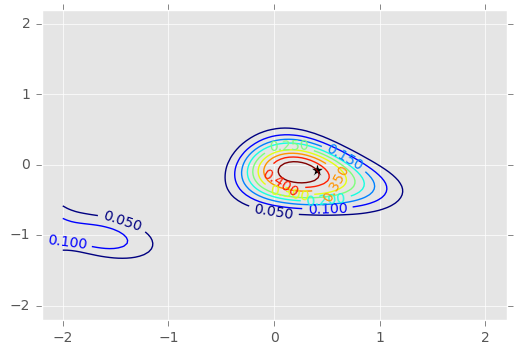

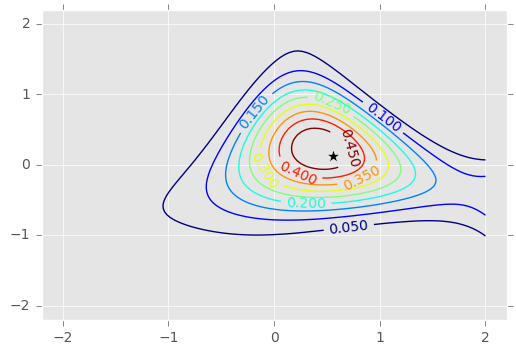

Estimated population means [ 0.49722076  0.18394957], stds [ 0.47635527  0.50358854]


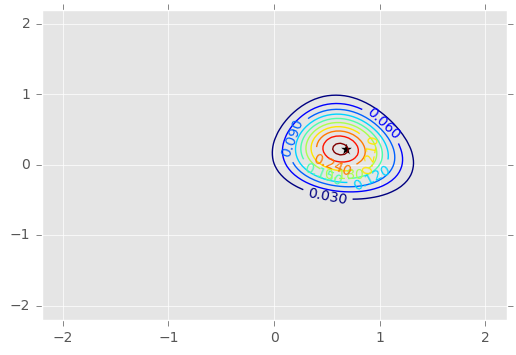

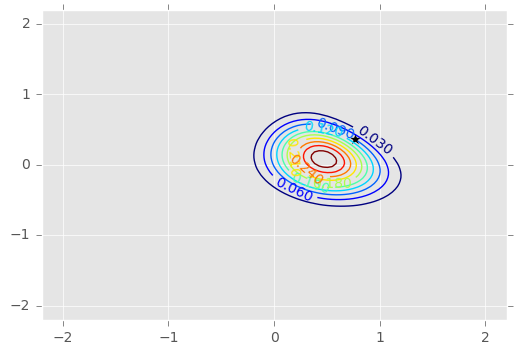

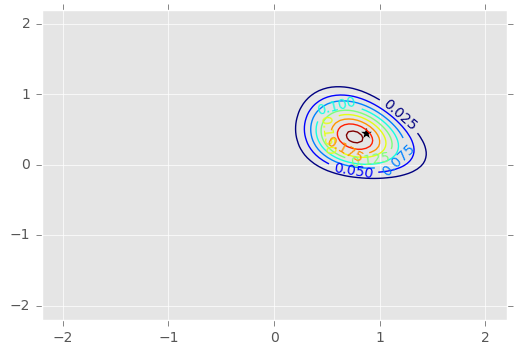

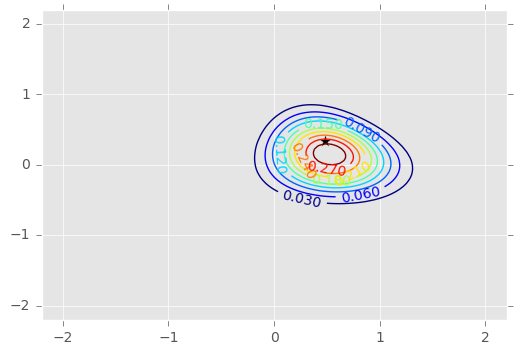

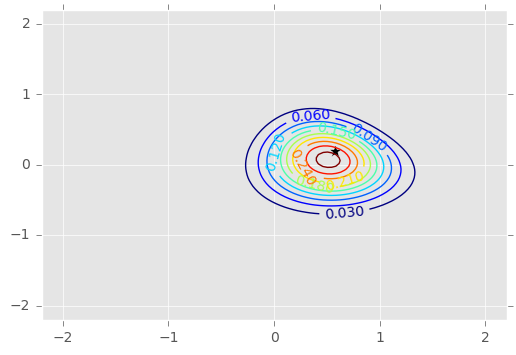

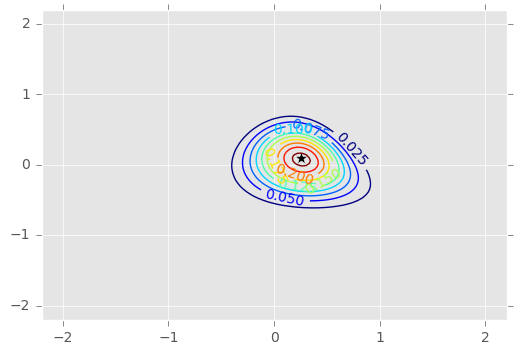

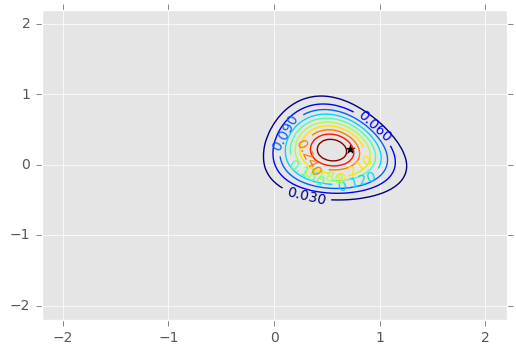

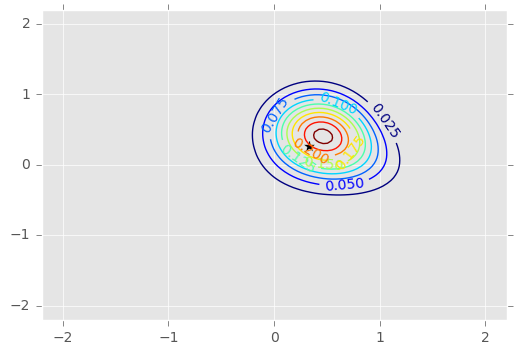

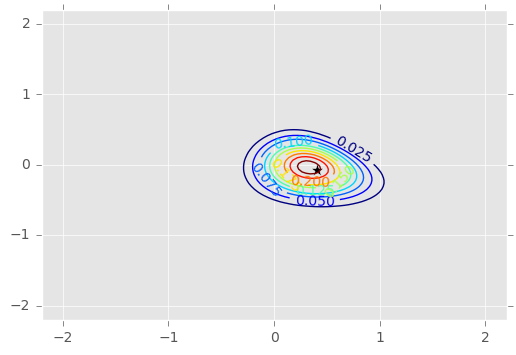

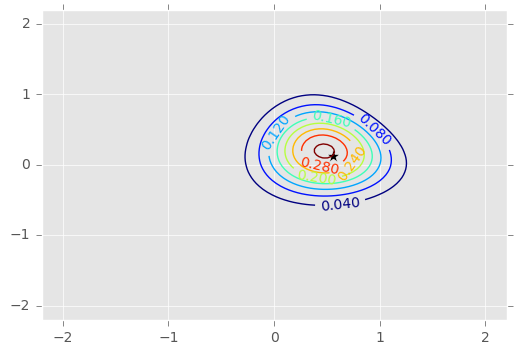

Estimated population means [ 0.49612815  0.18449009], stds [ 0.47704426  0.50459896]


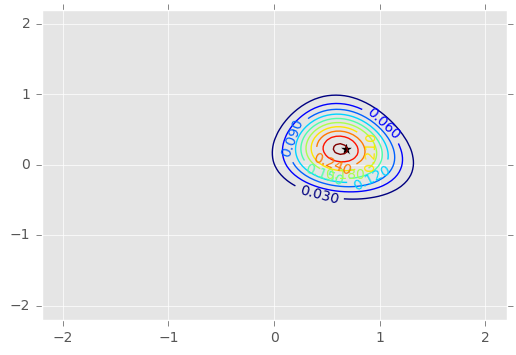

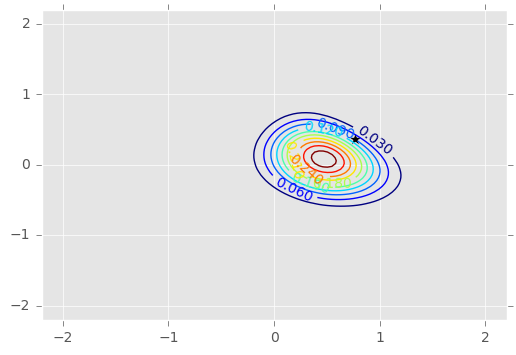

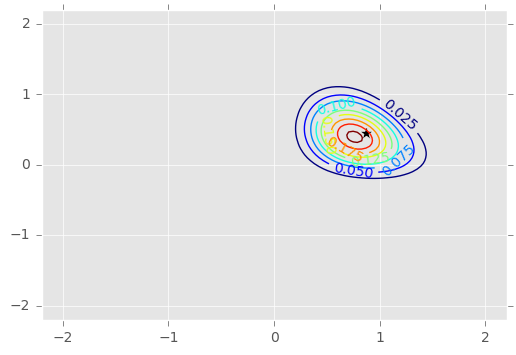

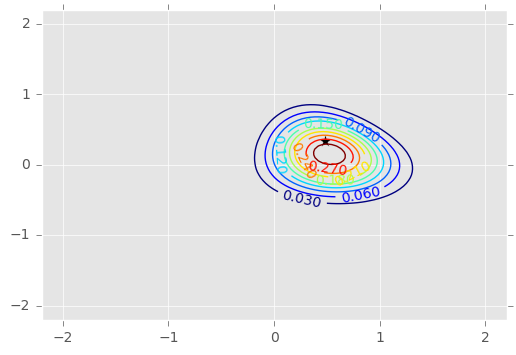

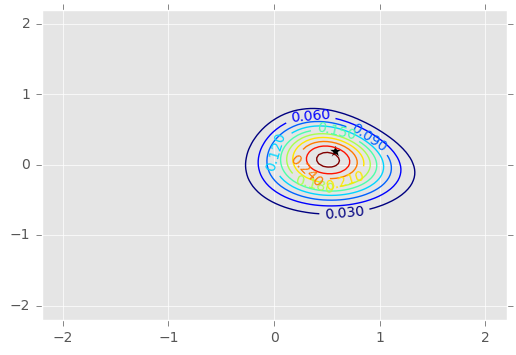

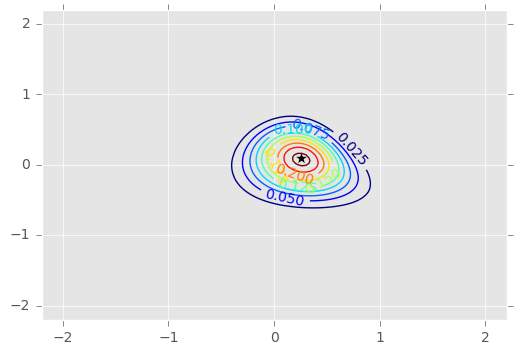

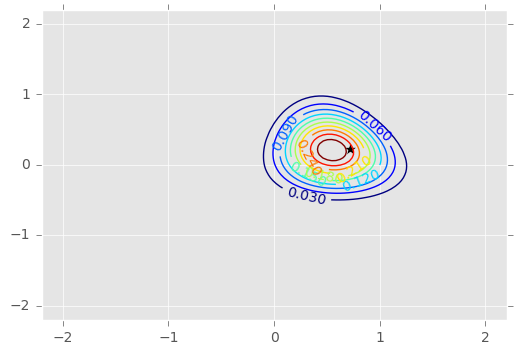

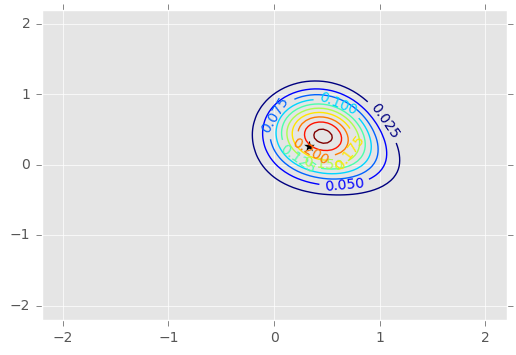

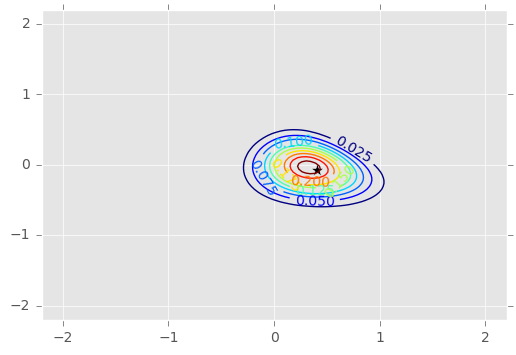

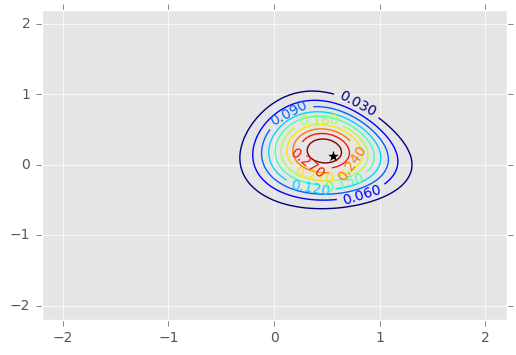

In [12]:
all_posteriors = list()
all_posteriors.append(posteriors)
for i in range(2):
    print_posterior(all_posteriors[-1])
    MAP_means, MAP_stds = estimate_MAP_statistics(all_posteriors[-1])
    print("Estimated population means {}, stds {}".format(MAP_means, MAP_stds))
    new_posteriors = do_new_posteriors(all_posteriors[-1], MAP_means, MAP_stds)
    all_posteriors.append(new_posteriors)
print_posterior(all_posteriors[-1])